Generate plots based on parametric dataset (compare 4 methods - two full signal and two trial-based):
* % of failed estimates (failed estimation and negative R-squared)
* ACF decline in specific range
* CI: 0 in the interval, width?
* R-squared (on unit level and as %)

Inclusion criteria:
* non zero bins
* 1 hz of activity
* R-squared > 0.5

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [30]:
#dataset_folder = project_folder_path + 'results\\mice\\dataset\\fig2_3_4a\\'
results_folder = project_folder_path + 'results\\mice\\dataset\\'

fig_folder = project_folder_path + 'results\\mice\\fig_draft_paper\\inclusion\\'

In [31]:
save_fig = True

### Load data

In [6]:
tau_plot_all_long_df = pd.read_pickle(results_folder + 'tau_unit_long_2_methods_var_lenght_with_nans_df.pkl')
tau_plot_all_long_df.rename(columns={'decline_150_250': 'acf_decline'}, inplace=True)

tau_plot_all_long_df['ci_zero_excluded'] = (
    (tau_plot_all_long_df['tau_lower'] > 0) | (tau_plot_all_long_df['tau_upper'] < 0)
).astype(int)

In [7]:
tau_plot_all_long_df

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,length,tau_ms,ecephys_structure_acronym,fr_hz_spont_30min,lv,tau_diff_rel,tau_diff_rel_log10,log_tau_ms,ci_zero_excluded
0,950913540,1.948056,9.974557e-01,2.898657e+00,8.352301e-01,False,acf_full,1,97.402817,VISam,6.038333,1.239003,235.687426,2.372336,1.988572,1
1,950915005,0.036402,3.640170e-02,3.640170e-02,-6.478507e-11,False,acf_full,1,1.820085,VISam,4.030556,0.628989,6.433986,0.808480,0.260092,1
2,950915018,0.041103,-9.490545e+07,9.490545e+07,-2.187119e-10,False,acf_full,1,2.055137,VISam,1.903333,0.557600,35.820737,1.554135,0.312841,0
3,950913798,0.047363,-1.613701e+06,1.613701e+06,-8.740766e-10,False,acf_full,1,2.368140,VISam,1.045556,0.683688,113.488412,2.054952,0.374407,0
4,950915049,0.090244,-3.715664e+02,3.717469e+02,3.452054e-01,False,acf_full,1,4.512213,VISam,0.953889,1.125211,260.322422,2.415512,0.654390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57745,951190507,25.842474,-4.203403e+01,9.371897e+01,7.966965e-01,False,sttc_full,30,1292.123708,VISrl,2.644444,0.795264,0.000000,-inf,3.111304,0
57746,951190510,0.036995,3.699459e-02,3.699459e-02,-1.920597e-10,False,sttc_full,30,1.849729,VISrl,0.751667,0.972755,0.000000,-inf,0.267108,1
57747,951190529,0.039435,-6.675920e+08,6.675920e+08,-1.075163e-09,False,sttc_full,30,1.971745,VISrl,5.059444,0.550662,0.000000,-inf,0.294851,0
57748,951190848,3.186280,1.527344e+00,4.845216e+00,8.300671e-01,True,sttc_full,30,159.313998,VISrl,0.303889,1.474969,0.000000,-inf,2.202254,1


In [8]:
tau_plot_all_long_df.keys()

Index(['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared',
       'acf_decline', 'method', 'length', 'tau_ms',
       'ecephys_structure_acronym', 'fr_hz_spont_30min', 'lv', 'tau_diff_rel',
       'tau_diff_rel_log10', 'log_tau_ms', 'ci_zero_excluded'],
      dtype='object')

### Plot overlall stats (without within unit comparison)

In [9]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'

colors = [color_acf_full, color_isttc_full]

#### % of failed estimates (failed estimation and negative R-squared)

In [21]:
def compute_exclusion(group):
    tau_nans = group['tau'].isna().sum()
    fit_r_squared_neg = (group['fit_r_squared'] < 0).sum()
    either_issue = ((group['tau'].isna()) | (group['fit_r_squared'] < 0)).sum()
    total = len(group)
    print(total)
    percent_tau_nans = 100 * tau_nans / total if total > 0 else 0
    percent_fit_r_squared_neg = 100 * fit_r_squared_neg / total if total > 0 else 0
    percent_either_issue = 100 * either_issue / total if total > 0 else 0
    return pd.Series({
        'tau_nans': tau_nans,
        'fit_r_squared_neg': fit_r_squared_neg,
        'exclusion': either_issue,
        'percent_tau_nans': percent_tau_nans,
        'percent_fit_r_squared_neg': percent_fit_r_squared_neg,
        'exclusion_perc': percent_either_issue
    })

exclusion_df = tau_plot_all_long_df.groupby(['method', 'length']).apply(compute_exclusion).reset_index()
exclusion_df

5775
5775
5775
5775
5775
5775
5775
5775
5775
5775


C:\Users\ipochino\AppData\Local\Temp\ipykernel_19244\956345375.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exclusion_df = tau_plot_all_long_df.groupby(['method', 'length']).apply(compute_exclusion).reset_index()


,method,length,tau_nans,fit_r_squared_neg,exclusion,percent_tau_nans,percent_fit_r_squared_neg,exclusion_perc
0,acf_full,1,101.0,1592.0,1693.0,1.748918,27.567100,29.316017
1,acf_full,5,0.0,1282.0,1282.0,0.000000,22.199134,22.199134
2,acf_full,10,0.0,1220.0,1220.0,0.000000,21.125541,21.125541
3,acf_full,20,0.0,1228.0,1228.0,0.000000,21.264069,21.264069
4,acf_full,30,0.0,1207.0,1207.0,0.000000,20.900433,20.900433
5,sttc_full,1,0.0,1620.0,1620.0,0.000000,28.051948,28.051948
6,sttc_full,5,0.0,1316.0,1316.0,0.000000,22.787879,22.787879
7,sttc_full,10,0.0,1291.0,1291.0,0.000000,22.354978,22.354978
8,sttc_full,20,0.0,1276.0,1276.0,0.000000,22.095238,22.095238
9,sttc_full,30,0.0,1296.0,1296.0,0.000000,22.441558,22.441558


In [19]:
def plot_one_threshold_jittered_lines(ax, df, field_to_plot, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        # ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        # ("sttc_trial_avg",     color_sttc_trail_avg,     "sttc_avg"),
        # ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        ("acf_full",           color_acf_full,           "acf_full"),
        ("sttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["length"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["length"]])
        y  = sub[field_to_plot].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

#### ACF decline and CI without zero

In [13]:
included_df = tau_plot_all_long_df.query('tau.notna() and fit_r_squared >= 0').copy()
print(f'len {len(included_df)}')
included_df.groupby(by='method', as_index=False).count()

len 44321


,method,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,length,tau_ms,ecephys_structure_acronym,fr_hz_spont_30min,lv,tau_diff_rel,tau_diff_rel_log10,log_tau_ms,ci_zero_excluded
0,acf_full,22245,22245,22245,22245,22245,22245,22245,22245,22245,22245,22245,22245,22245,22245,22245
1,sttc_full,22076,22076,22076,22076,22076,22076,22076,22076,22076,22076,22076,22076,22076,22076,22076


In [22]:
acf_decline_df = included_df.groupby(by=['method','length']).agg(
    num_true=('acf_decline', lambda x: x.sum())
).assign(
    total=5775,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
acf_decline_df

,method,length,num_true,total,percent_true
0,acf_full,1,2135,5775,36.969697
1,acf_full,5,2761,5775,47.809524
2,acf_full,10,2921,5775,50.580087
3,acf_full,20,3015,5775,52.207792
4,acf_full,30,3086,5775,53.437229
5,sttc_full,1,2158,5775,37.367965
6,sttc_full,5,2620,5775,45.367965
7,sttc_full,10,2790,5775,48.311688
8,sttc_full,20,2928,5775,50.701299
9,sttc_full,30,2976,5775,51.532468


In [23]:
ci_zero_df = included_df.groupby(by=['method','length']).agg(
    num_true=('ci_zero_excluded', lambda x: x.sum())
).assign(
    total=5775,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
ci_zero_df

,method,length,num_true,total,percent_true
0,acf_full,1,2091,5775,36.207792
1,acf_full,5,3263,5775,56.502165
2,acf_full,10,3597,5775,62.285714
3,acf_full,20,3792,5775,65.662338
4,acf_full,30,3897,5775,67.480519
5,sttc_full,1,2017,5775,34.926407
6,sttc_full,5,3211,5775,55.601732
7,sttc_full,10,3539,5775,61.281385
8,sttc_full,20,3738,5775,64.727273
9,sttc_full,30,3816,5775,66.077922


#### R-squared > 0.5

In [24]:
fit_r2_df = included_df.groupby(by=['method','length']).agg(
    num_true=('fit_r_squared', lambda x: (x >= 0.5).sum())
).assign(
    total=5775,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
fit_r2_df

,method,length,num_true,total,percent_true
0,acf_full,1,2960,5775,51.255411
1,acf_full,5,4065,5775,70.389610
2,acf_full,10,4270,5775,73.939394
3,acf_full,20,4383,5775,75.896104
4,acf_full,30,4436,5775,76.813853
5,sttc_full,1,2888,5775,50.008658
6,sttc_full,5,4014,5775,69.506494
7,sttc_full,10,4209,5775,72.883117
8,sttc_full,20,4327,5775,74.926407
9,sttc_full,30,4351,5775,75.341991


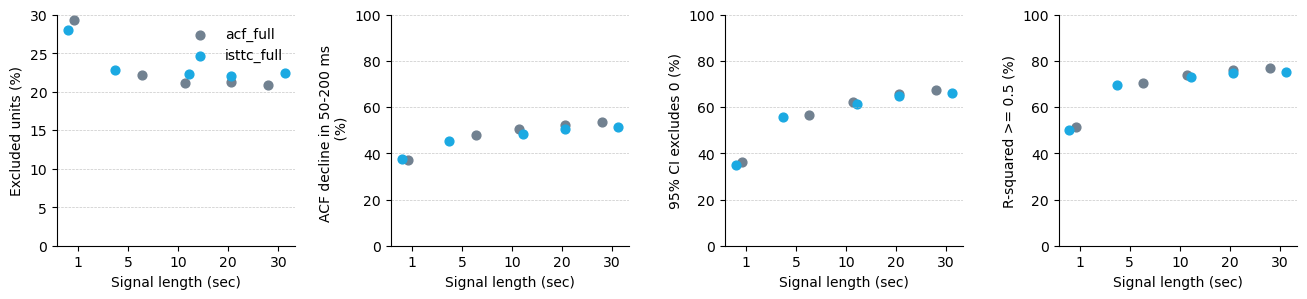

In [35]:
fig, axes = plt.subplots(1,4,figsize=(16,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold_jittered_lines(axes[0],
    exclusion_df, 'exclusion_perc',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[1],
    acf_decline_df, 'percent_true',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    ci_zero_df, 'percent_true',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[3],
    fit_r2_df, 'percent_true',
    jitter=0.3, seed=42)

axes[0].set_ylabel('Excluded units (%)')
axes[1].set_ylabel('ACF decline in 50-200 ms \n (%)')
axes[2].set_ylabel('95% CI excludes 0 (%)')
axes[3].set_ylabel('R-squared >= 0.5 (%)')

axes[0].set_ylim([0, 30])
axes[1].set_ylim([0, 100])
axes[2].set_ylim([0, 100])
axes[3].set_ylim([0, 100])

for ax in axes.flat:
    ax.set_xlabel('Signal length (sec)')
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'inclusion_durations.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'inclusion_durations.svg' , bbox_inches='tight')

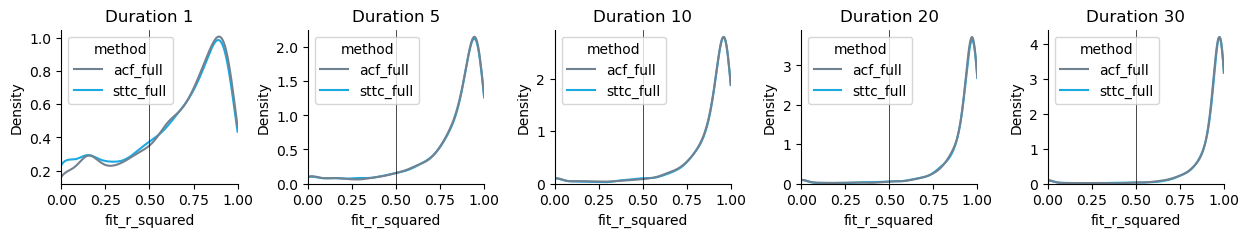

In [34]:
# R2 as KDE plots

fig, axes = plt.subplots(1,5, figsize=(15,2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

durations_s_l = list(included_df["length"].unique())

for duration_idx, duration in enumerate(durations_s_l):
    sns.kdeplot(
        data=included_df.query('length == @duration'), 
        x='fit_r_squared', 
        hue='method', 
        hue_order=['acf_full', 'sttc_full'],    
        clip=(0, 1),
        common_norm=True,  
        fill=False,
        palette=colors,
        legend=True,
        ax=axes[duration_idx]
    )
    axes[duration_idx].set_title(f'Duration {duration}')

for ax in axes.flat:
    ax.axvline(x=0.5, lw=0.5, c='k')
    ax.set_xlim([0,1])
    ax.set_xticks(np.linspace(0, 1, 5))

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'r2_kde_plot_durations.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r2_kde_plot_durations.svg' , bbox_inches='tight')